In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


In [3]:
# Batheymetry averaged about the core
df_eddies = compute_core_mean(
    df_eddies,
    X_grid, Y_grid,
    mask_rho,
    fixed_field=h,
    colname="h"
)
# df_eddies['h'] = h[df_eddies.ic, df_eddies.jc]

# Coriolis
f = np.transpose(dataset.variables['f'], axes=(1, 0))
df_eddies['f'] = f[df_eddies.ic, df_eddies.jc]

# Potential Vorticity
df_eddies['q'] = (df_eddies.w + df_eddies.f) / df_eddies.h

# Slope Magntiude
dhdx, dhdy = phys_grad(h, X_grid*1e3, Y_grid*1e3, mask_rho) 
s = np.hypot(dhdx, dhdy)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]


In [4]:
# topographic q gradient
dh_dTN = - (np.sin(angle) * dhdx + np.cos(angle) * dhdy)
q_grad_topo = -f * dh_dTN / h**2
df_eddies['top_q_grad'] = -(df_eddies.w + df_eddies.f) / df_eddies.h**2 * dh_dTN[df_eddies.ic, df_eddies.jc] 
df_eddies['top_q_grad_abs'] = df_eddies.top_q_grad.abs()

# planetary q gradient
dfdx, dfdy = phys_grad(f, X_grid*1e3, Y_grid*1e3, mask_rho)
df_dTN = - (np.sin(angle) * dfdx + np.cos(angle) * dfdy)
q_grad_plan = df_dTN / h
df_eddies['plan_q_grad'] = q_grad_plan[df_eddies.ic, df_eddies.jc]
df_eddies['plan_q_grad_abs'] = df_eddies.plan_q_grad.abs()

# potential vorticity gradient
df_eddies['q_grad'] = (df_eddies.top_q_grad + df_eddies.plan_q_grad).abs()

# Beta
df_eddies['beta'] = df_dTN[df_eddies.ic, df_eddies.jc]
q_grad = q_grad_plan + q_grad_topo



In [5]:
def beta_panel(
        xcap1_min=None, xcap1_max=None, xfit1_min=None, xfit1_max=None, split1=None, cbar_cap1=None,
        xcap2_min=None, xcap2_max=None, xfit2_min=None, xfit2_max=None, split2=None, cbar_cap2=None,
        xcap3_min=None, xcap3_max=None, xfit3_min=None, xfit3_max=None, split3=None, cbar_cap3=None,
        scatter=False, abs_vals=True, ylim=None,
        sharey=True, linfit=True, figsize=(10, 12)
    ):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(3, 2, width_ratios=[1.5, 1])

    if sharey:
        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[1, 0], sharey=ax0)
        ax2 = fig.add_subplot(gs[2, 0], sharey=ax0)
    else:
        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[2, 0])

    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, 1])

    styles = {
        'AE': {'line': 'darkred',  'fill': 'red'},
        'CE': {'line': 'navy',     'fill': 'blue'}
    }

    def beta_row(ax, col_abs, col_signed,
                 xcap_min, xcap_max, xfit_min, xfit_max,
                 split, beta_label_fit, xlabel_tex, use_abs=True):
        df_all = df_eddies.copy()
        if use_abs:
            df_all = df_all.dropna(subset=[col_abs, 'TiltDis'])
            vals = df_all[col_abs].values
        else:
            df_all = df_all.dropna(subset=[col_signed, 'TiltDis'])
            vals = df_all[col_signed].values
    
        tilt_all = df_all['TiltDis'].values
    
        if split is None:
            split = 0.5 * (xcap_min + xcap_max)
    
        mask_cap = (vals >= xcap_min) & (vals <= xcap_max)
        N_all = vals[mask_cap]
        if N_all.size < 5:
            return split, np.nan, np.nan
    
        nbins = 30
        bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
        bins = np.unique(bins)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        maskL = bin_centers < split
    
        med_above = {'AE': np.nan, 'CE': np.nan}
    
        for cyc in ['AE', 'CE']:
            df_cyc = df_all[df_all.Cyc == cyc].copy()
            if use_abs:
                xval = df_cyc[col_abs].values
            else:
                xval = df_cyc[col_signed].values
            tilt = df_cyc['TiltDis'].values
    
            mask_beta = (xval >= xcap_min) & (xval <= xcap_max)
            xval = xval[mask_beta]
            tilt = tilt[mask_beta]
    
            if xval.size == 0:
                continue
    
            digitized = np.digitize(xval, bins)
            med = np.array([np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))])
            q25 = np.array([np.nanquantile(tilt[digitized == i], 0.25) for i in range(1, len(bins))])
            q75 = np.array([np.nanquantile(tilt[digitized == i], 0.75) for i in range(1, len(bins))])
    
            if scatter:
                ax.scatter(xval[xval < split], tilt[xval < split],
                           s=1, alpha=0.08, marker='.', color=styles[cyc]['fill'])
    
            ax.plot(bin_centers[maskL], med[maskL], lw=2.5, color=styles[cyc]['line'], alpha=.7)
            ax.fill_between(bin_centers[maskL], q25[maskL], q75[maskL],
                            color=styles[cyc]['fill'], alpha=0.12)
    
            if linfit and (xfit_min is not None) and (xfit_max is not None):
                pmin_L, pmax_L = max(xcap_min, xfit_min), min(split, xfit_max)
                mask_regL = (xval >= pmin_L) & (xval <= pmax_L)
                if mask_regL.sum() > 2:
                    xr, yr = xval[mask_regL], tilt[mask_regL]
                    m, c, r, p, se = linregress(xr, yr)
                    x_fit = np.linspace(pmin_L, pmax_L, 200)
                    y_fit = m * x_fit + c
                    ax.plot(x_fit, y_fit, '--', lw=2, color=styles[cyc]['fill'],
                            label=fr"{cyc}: TD={m:.2e} {beta_label_fit} "
                                  f"{r'$-$' if c<0 else r'$+$'} {np.abs(c):.2f}")
    
            # median above split for this cyc
            if use_abs:
                series_cyc = df_cyc[col_abs].values
            else:
                series_cyc = df_cyc[col_signed].values
            mask_above_cyc = (series_cyc >= split) #& (series_cyc <= xcap_max)
            if mask_above_cyc.sum() > 0:
                med_above[cyc] = np.nanmedian(df_cyc['TiltDis'].values[mask_above_cyc])
    
        ax.set_xlim(xcap_min, split)
        if ylim is not None:
            ax.set_ylim(0, ylim)
        ax.set_xlabel(xlabel_tex)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylabel('Tilt Distance (km)')
        ax.legend(fontsize=None, loc='lower right')
    
        return split, med_above['AE'], med_above['CE']

    # -------- Row 1: planetary beta --------
    if split1 is None and (xcap1_min is not None and xcap1_max is not None):
        split1 = 0.5 * (xcap1_min + xcap1_max)
    split1, med1_above_AE, med1_above_CE  = beta_row(
        ax0,
        col_abs='plan_q_grad_abs', col_signed='plan_q_grad',
        xcap_min=xcap1_min, xcap_max=xcap1_max,
        xfit_min=xfit1_min, xfit_max=xfit1_max,
        split=split1,
        beta_label_fit=r'$x$',
        xlabel_tex=r'Planetary $\frac{dq}{dy}: |\frac{1}{h}\ \frac{df}{dy}|$',
        use_abs=abs_vals
    )
    # print(f"Median TiltDis for β_plan ≥ {split1:.2e}: {med1_above:.2f} km")
    ax0.text(3.9e-15, 40, f"Median tilt dist. for $x$ ≥ {split1:.2e}:\n AE {med1_above_AE:.2f} km, CE {med1_above_CE:.2f} km")

    # -------- Row 2: topographic beta --------
    if split2 is None and (xcap2_min is not None and xcap2_max is not None):
        split2 = 0.5 * (xcap2_min + xcap2_max)
    split2, med2_above_AE, med2_above_CE = beta_row(
        ax1,
        col_abs='top_q_grad_abs', col_signed='top_q_grad',
        xcap_min=xcap2_min, xcap_max=xcap2_max,
        xfit_min=xfit2_min, xfit_max=xfit2_max,
        split=split2,
        beta_label_fit=r'$x$',
        xlabel_tex=r'Topographic $\frac{dq}{dy}: |-\frac{\omega+f}{h^2}\ \frac{dh}{dy}|$',
        use_abs=abs_vals
    )
    # print(f"Median TiltDis for β_top ≥ {split2:.2e}: {med2_above:.2f} km")
    ax1.text(5e-15, 40, f"Median tilt dist. for $x$ ≥ {split2:.2e}:\n AE {med2_above_AE:.2f} km, CE {med2_above_CE:.2f} km")

    # -------- Row 3: total beta --------
    if split3 is None and (xcap3_min is not None and xcap3_max is not None):
        split3 = 0.5 * (xcap3_min + xcap3_max)
    split3, med3_above_AE, med3_above_CE  = beta_row(
        ax2,
        col_abs='q_grad', col_signed='q_grad',
        xcap_min=xcap3_min, xcap_max=xcap3_max,
        xfit_min=xfit3_min, xfit_max=xfit3_max,
        split=split3,
        beta_label_fit=r'$x$',
        xlabel_tex=r'Total $\frac{dq}{dy}=|\frac{1}{h}\ \frac{df}{dy}-\frac{\omega+f}{h^2}\ \frac{dh}{dy}|$',
        use_abs=False
    )
    # print(f"Median TiltDis for x ≥ {split3:.2e}: {med3_above:.2f} km")
    ax2.text(5e-15, 40, f"Median tilt dist. for $x$ ≥ {split3:.2e}:\n AE {med3_above_AE:.2f} km, CE {med3_above_CE:.2f} km")

    if ylim is not None:
        for ax in [ax0, ax1, ax2]:
            ax.set_ylim(0, ylim)

    # -----------------------------
    # ROW 1, COL 3: planetary beta map
    # -----------------------------
    ax3.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
    Z_clipped = np.clip(np.abs(q_grad_plan), split1, cbar_cap1 or np.abs(q_grad_plan).max())
    im3 = ax3.contourf(
        X_grid, Y_grid, Z_clipped, cmap='Blues',
        levels=np.linspace(split1, cbar_cap1 or np.abs(q_grad_plan).max(), 10)
    )
    fig.colorbar(im3, ax=ax3, location='right', label=r'm$^{-2}$s$^{-1}$')
    im3 = ax3.contourf(
        X_grid, Y_grid, np.abs(q_grad_plan), cmap='Greens',
        levels=np.linspace(xcap1_min, split1, 10)
    )
    fig.colorbar(im3, ax=ax3, location='right')

    ax3.set_title(r'$\frac{dq}{dy}_{\rm Plan} = |\frac{1}{h}\ \frac{df}{dy}|$')

    c1 = ax3.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=0.5)
    ax3.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax3.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=0.5)
    ax3.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_xlabel('x (km)'); ax3.set_ylabel('y (km)')   
    
    # -----------------------------
    # ROW 2, COL 3: topographic beta map
    # -----------------------------
    ax4.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
    Z_clipped = np.clip(np.abs(q_grad_topo), split2, cbar_cap2 or np.abs(q_grad_topo).max())
    im4 = ax4.contourf(
        X_grid, Y_grid, Z_clipped,
        cmap='Blues', levels=np.linspace(split2, cbar_cap2 or np.abs(q_grad_topo).max(), 9),
    )
    fig.colorbar(im4, ax=ax4, location='right', label=r'm$^{-2}$s$^{-1}$')
    im4 = ax4.contourf(
        X_grid, Y_grid, np.abs(q_grad_topo),
        cmap='Greens', levels=np.linspace(xcap2_min, split2, 9),
    )
    fig.colorbar(im4, ax=ax4, location='right')

    c1 = ax4.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=0.5)
    ax4.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax4.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=0.5)
    ax4.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    ax4.set_title(r'$\frac{dq}{dy}_{\rm Top} = |-\frac{f}{h^2}\ \frac{dh}{dy}|$')
    ax4.set_aspect('equal', adjustable='box')
    ax4.set_xlabel('x (km)'); ax4.set_ylabel('y (km)')   
    
    # -----------------------------
    # ROW 3, COL 3: total beta map
    # -----------------------------
    ax5.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
    Z_clipped = np.clip(np.abs(q_grad), split3, cbar_cap3 or np.abs(q_grad).max())
    im5 = ax5.contourf(
        X_grid, Y_grid,
        np.where(mask_rho, Z_clipped, np.nan),
        levels=np.linspace(split3, cbar_cap3 or np.abs(q_grad).max(), 9),
        cmap='Blues'
    )
    fig.colorbar(im5, ax=ax5, location='right', label=r'm$^{-2}$s$^{-1}$')
    im5 = ax5.contourf(
        X_grid, Y_grid,
        np.where(mask_rho, np.abs(q_grad), np.nan),
        levels=np.linspace(xcap3_min, split3, 9),
        cmap='Greens'
    )
    fig.colorbar(im5, ax=ax5, location='right')

    c1 = ax5.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=0.5)
    ax5.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax5.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=0.5)
    ax5.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    ax5.set_title(r'|$\frac{dq}{dy}_{\rm total}$|')
    ax5.set_aspect('equal', adjustable='box')
    ax5.set_xlabel('x (km)'); ax5.set_ylabel('y (km)')     

    plt.show()


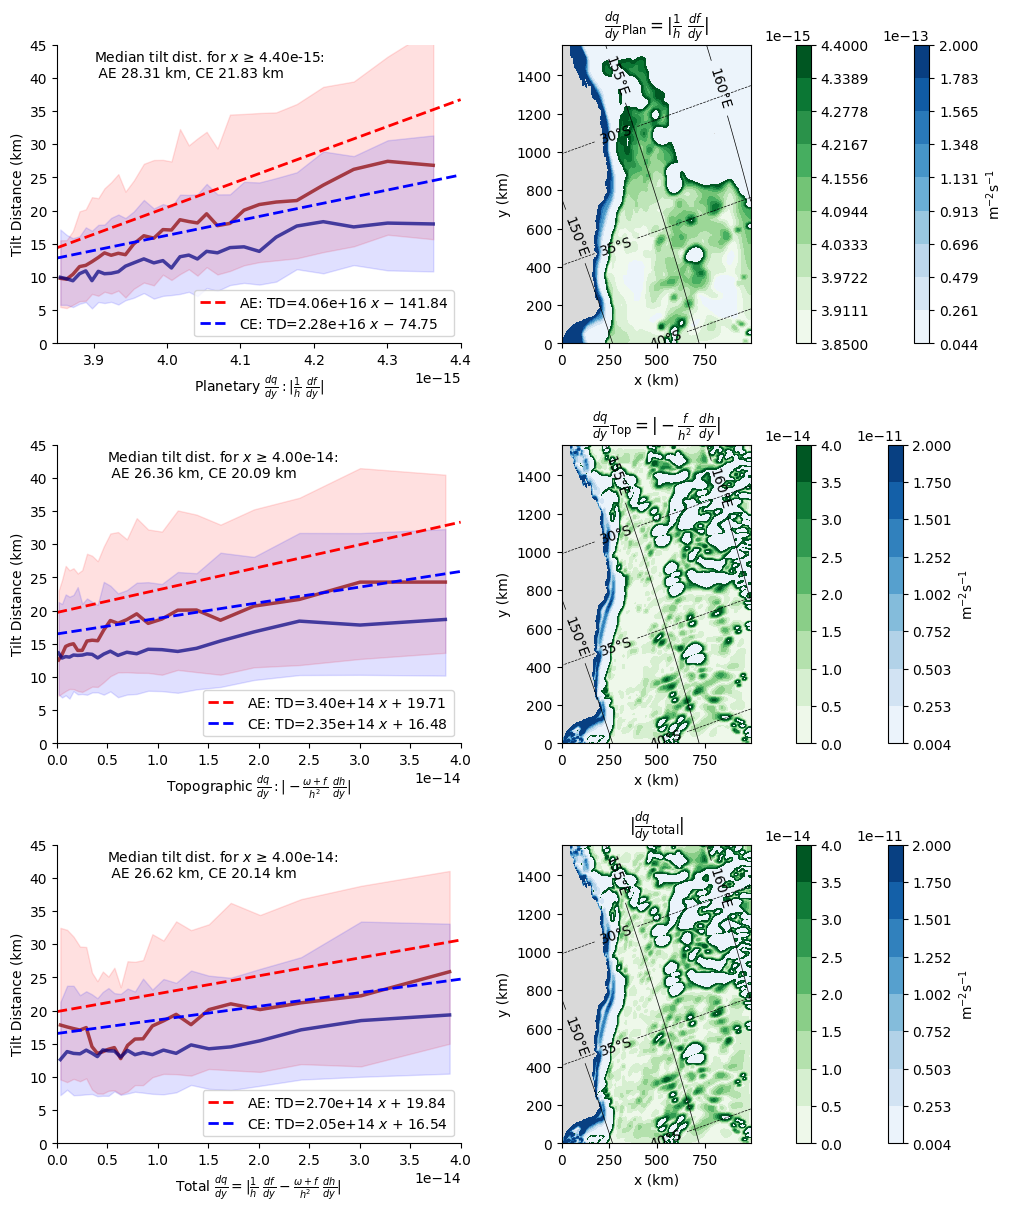

In [6]:
beta_panel(xcap1_min=3.85e-15, xcap1_max=4.4e-15, xfit1_min=3.85e-15, xfit1_max=4.4e-15, cbar_cap1=2e-13, split1=4.4e-15, 
             xcap2_min=0, xcap2_max=1.3e-10, xfit2_min=0, xfit2_max=.4e-13, cbar_cap2=.2e-10, split2=4e-14, 
             xcap3_min=0, xcap3_max=1.3e-10, xfit3_min=0, xfit3_max=.4e-13, cbar_cap3=.2e-10, split3=4e-14, 
             scatter=False, ylim=45, sharey=False,
             linfit=True, figsize=(10, 12))


In [46]:
# Slope Magntiude
h = np.transpose(dataset.variables['h'], axes=(1, 0))
dhdx, dhdy = phys_grad(h, X_grid*1e3, Y_grid*1e3, mask_rho)
s = np.hypot(dhdx, dhdy)

# topographic q gradient
dh_dN = - (np.sin(angle) * dhdx + np.cos(angle) * dhdy)
dh_dE = - (np.cos(angle) * dhdx - np.sin(angle) * dhdy)

# planetary q gradient
f = np.transpose(dataset.variables['f'], axes=(1, 0))
dfdx, dfdy = phys_grad(f, X_grid*1e3, Y_grid*1e3, mask_rho)
df_dN = - (np.sin(angle) * dfdx + np.cos(angle) * dfdy)
df_dE = - (np.cos(angle) * dfdx - np.sin(angle) * dfdy)

beta = df_dN


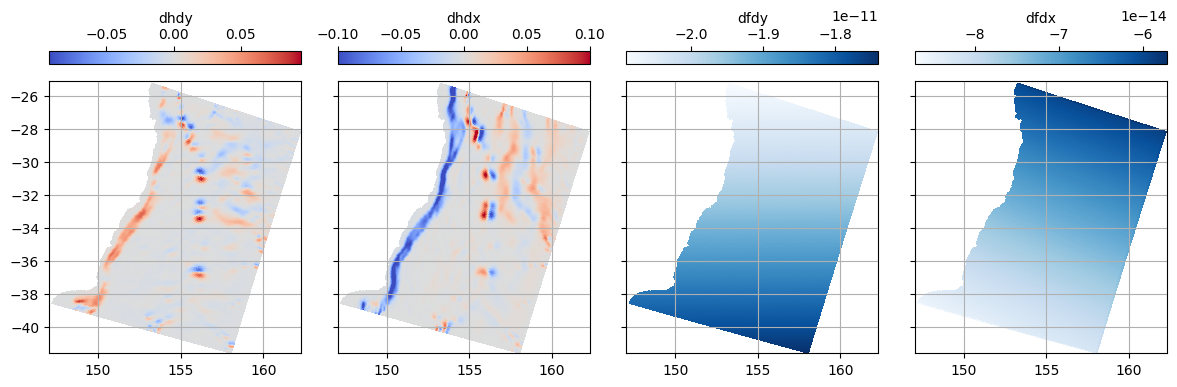

In [8]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 4))
c = axs[0].pcolor(lon_rho, lat_rho, dh_dN, cmap='coolwarm')
plt.colorbar(c, ax=axs[0], location='top', label='dhdy')
c = axs[1].pcolor(lon_rho, lat_rho, dh_dE, cmap='coolwarm', vmin=-.1, vmax=.1)
plt.colorbar(c, ax=axs[1], location='top', label='dhdx')

c = axs[2].pcolor(lon_rho, lat_rho, df_dN, cmap='Blues')
plt.colorbar(c, ax=axs[2], location='top', label='dfdy')
c = axs[3].pcolor(lon_rho, lat_rho, df_dE, cmap='Blues')
plt.colorbar(c, ax=axs[3], location='top', label='dfdx')
for ax in axs:
    ax.axis('equal'); ax.grid('on')
plt.tight_layout()


<h2>
QG PV Theory <br>
$q = \frac{\omega + f}{h}$ <br>
$\frac{\partial q}{\partial x} = -\frac{\omega + f}{h^2}\frac{\partial h}{\partial x}$ <br>
$\frac{\partial q}{\partial y} = \frac{1}{h}\frac{\partial f}{\partial y} - \frac{\omega + f}{h^2}\frac{\partial h}{\partial y}$
</h2>


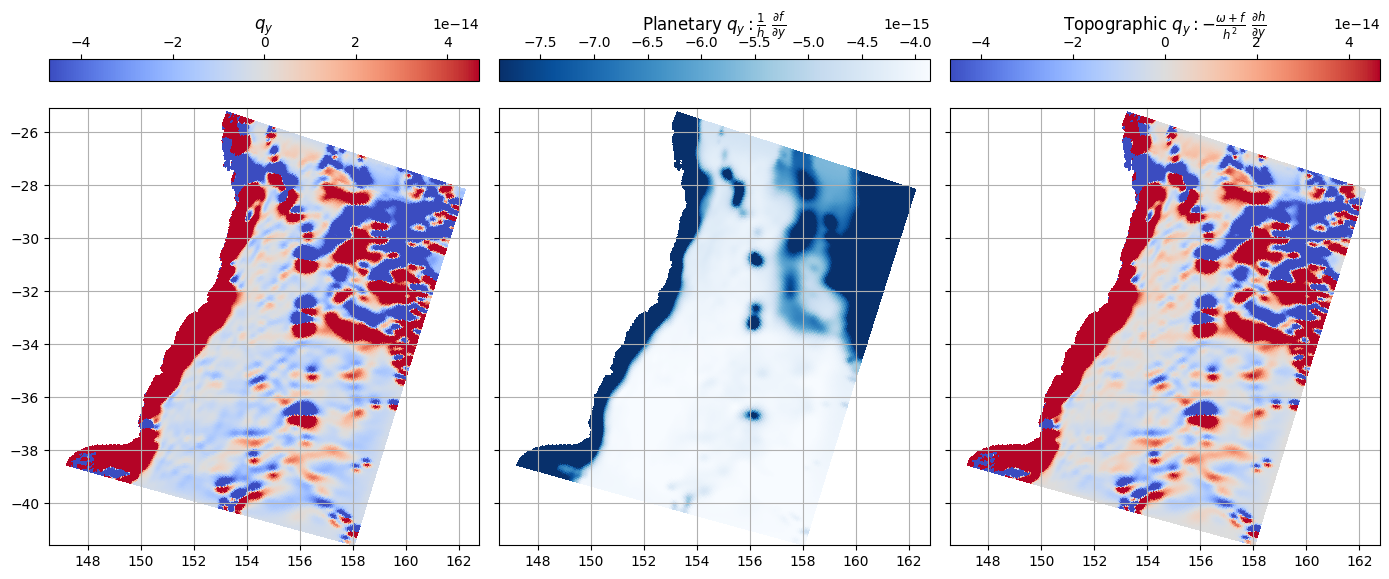

In [112]:
Gradq = 1 / h * df_dN - (f / h**2) * dh_dN
Gradq_plan = 1 / h * df_dN
Gradq_topo = - (f / h**2) * dh_dN

df_eddies['Gradq_plan'] = Gradq_plan[df_eddies.ic, df_eddies.jc]
df_eddies['Gradq_topo'] = - ((df_eddies.w + f[df_eddies.ic, df_eddies.jc]) / h[df_eddies.ic, df_eddies.jc]**2) * (dh_dN[df_eddies.ic, df_eddies.jc])
df_eddies['Gradq'] = df_eddies.Gradq_plan + df_eddies.Gradq_topo 
df_eddies['beta'] = df_dN[df_eddies.ic, df_eddies.jc]

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 6))
lo, hi = np.percentile(df_eddies.Gradq, [10, 90])
p = min(abs(lo), abs(hi))
c = axs[0].pcolor(lon_rho, lat_rho, Gradq, cmap='coolwarm', vmin=-p, vmax=p)#, vmin=-3e-14, vmax=3e-14)
cb = plt.colorbar(c, ax=axs[0], location='top')
cb.set_label(label=r'$q_y$', fontsize=12)

lo, hi = np.percentile(df_eddies.Gradq_plan, [10, 90])
c = axs[1].pcolor(lon_rho, lat_rho, Gradq_plan, cmap='Blues_r', vmin=lo, vmax=hi)#, vmin=-6e-15)
cb = plt.colorbar(c, ax=axs[1], location='top')
cb.set_label(label=r'Planetary $q_y: \frac{1}{h}\ \frac{\partial f}{\partial y}$', fontsize=12)

lo, hi = np.percentile(df_eddies.Gradq_topo, [10, 90])
p = min(abs(lo), abs(hi))
c = axs[2].pcolor(lon_rho, lat_rho, Gradq_topo, cmap='coolwarm', vmin=-p, vmax=p)#, vmin=-3e-14, vmax=3e-14)
cb = plt.colorbar(c, ax=axs[2], location='top', label=r'Topographic $q_y: -\frac{\omega + f}{h^2}\ \frac{\partial h}{\partial y}$')
cb.set_label(label=r'Topographic $q_y: -\frac{\omega + f}{h^2}\ \frac{\partial h}{\partial y}$', fontsize=12)

for ax in axs:
    ax.axis('equal'); ax.grid('on')
plt.tight_layout()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


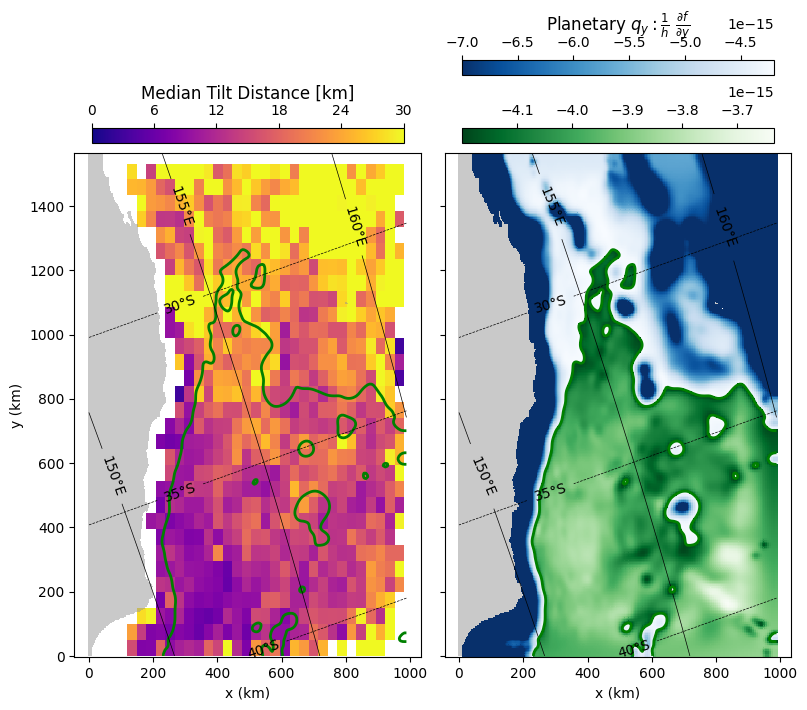

In [114]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: 
            return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])

    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)

    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))

    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))

    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)

    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 30
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)

def binned_median(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(v)

    ix, iy, v = ix[ok], iy[ok], v[ok]
    flat = iy * nx + ix

    hmed = np.full(nx * ny, np.nan)
    for k in np.unique(flat):
        hmed[k] = np.nanmedian(v[flat == k])

    return hmed.reshape(ny, nx)

# ---------- 1 x 2 FIGURE ----------

fig, axs = plt.subplots(1, 2, figsize=(8, 7), sharey=True, constrained_layout=True)

# --- Left panel: all eddies together ---
ax = axs[0]

df_all = df_eddies.copy()
df_all = df_all.sort_values('TiltDis', kind='mergesort', ignore_index=True)

ax.contour(X_grid, Y_grid, Gradq_plan, levels=[-4.2e-15], colors='g', linestyles='-', linewidths=2)

H = binned_median(df_all.xc.values, df_all.yc.values,
                  df_all.TiltDis.values, xbins, ybins)

m = ax.pcolormesh(xbins, ybins, H, cmap='plasma', norm=norm,
                  shading='auto', rasterized=True)
cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
cb.set_label('Median Tilt Distance [km]', fontsize=12)
cb.set_ticks(np.linspace(vmin, vmax, 6))

ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
            levels=[0.5, 1.5], cmap='Greys', alpha=.5)

c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                colors='k', linewidths=.5)
ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                colors='k', linewidths=.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

ax.axis('equal')
ax.set_xlim(X_grid.min(), X_grid.max())
ax.set_ylim(Y_grid.min(), Y_grid.max())
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
# ax.set_title('All eddies: median tilt distance')

# --- Right panel: planetary q_y ---
ax2 = axs[1]
ax2.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
            levels=[0.5, 1.5], cmap='Greys', alpha=.5)

# # All

# lo, hi = np.percentile(df_eddies.Gradq_plan, [10, 90])
# c = ax2.pcolor(X_grid, Y_grid, Gradq_plan,
#                cmap='Blues_r', vmin=lo, vmax=hi)
# cb = fig.colorbar(c, ax=ax2, location='top', pad=0.02, shrink=0.9)
# cb.set_label(r'Planetary $q_y: \frac{1}{h}\ \frac{\partial f}{\partial y}$', fontsize=12)

# Seperated
field1 = np.where(Gradq_plan < -4.2e-15, Gradq_plan, np.nan)
# lo, hi = np.percentile(field1, [10, 90])
lo, hi = np.percentile(df_eddies.Gradq_plan, [10, 90])
c = ax2.pcolor(X_grid, Y_grid, field1,
               cmap='Blues_r', vmin=-7e-15)#, vmin=lo, vmax=hi)
cb = fig.colorbar(c, ax=ax2, location='top', pad=0.02, shrink=0.9)
cb.set_label(r'Planetary $q_y: \frac{1}{h}\ \frac{\partial f}{\partial y}$', fontsize=12)

field2 = np.where(Gradq_plan >= -4.2e-15, Gradq_plan, np.nan)
lo, hi = np.percentile(field2, [10, 90])
c = ax2.pcolor(X_grid, Y_grid, field2,
               cmap='Greens_r')#, vmin=lo, vmax=hi)
cb = fig.colorbar(c, ax=ax2, location='top', pad=0.02, shrink=0.9)
# cb.set_label(r'Planetary $q_y: \frac{1}{h}\ \frac{\partial f}{\partial y}$', fontsize=12)

# the rest
c1 = ax2.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                colors='k', linewidths=.5)
ax2.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
c2 = ax2.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                colors='k', linewidths=.5)
ax2.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

ax2.contour(X_grid, Y_grid, Gradq_plan, levels=[-4.2e-15], colors='g', linestyles='-', linewidths=2)

ax2.axis('equal')
ax2.set_xlabel('x (km)')
# ax2.set_ylabel('y (km)')
# ax2.set_title('Planetary $q_y$')

# plt.tight_layout()
plt.show()


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


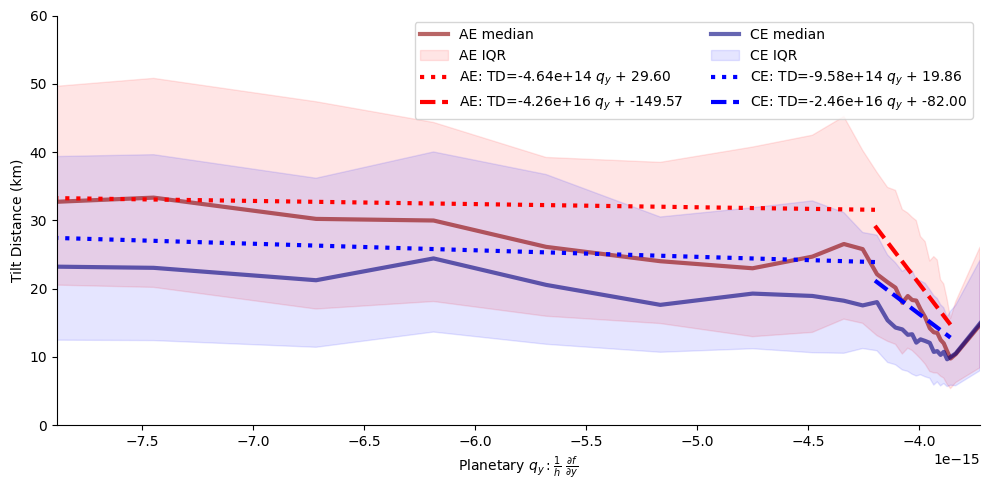

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['Gradq_plan'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.Gradq_plan.min(), df_all.Gradq_plan.max()  # <-- set your limits 

mask_cap = (df_all.Gradq_plan >= x_min) & (df_all.Gradq_plan <= x_max)
N_all = df_all[mask_cap].Gradq_plan.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['Gradq_plan', 'TiltDis'])

    xval = df_masked['Gradq_plan'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    ls = [':', '--', '-.']
    for l, (Nmin, Nmax) in enumerate(zip([xval.min(), -4.2e-15, -3.86e-15],
                          [-4.2e-15, -3.86e-15, xval.max()])):
        if l != 2:
            mask_reg = (xval >= Nmin) & (xval <= Nmax)
        
            if mask_reg.sum() > 2:
                xr = xval[mask_reg]
                yr = tilt[mask_reg]
                m, c, r, p, se = linregress(xr, yr)
                x_fit = np.linspace(Nmin, Nmax, 200)
                y_fit = m * x_fit + c
        
                ax.plot(x_fit, y_fit, ls[l], lw=3, color=styles[cyc]['fill'],
                        label=fr'{cyc}: TD={m:.2e} $q_y$ + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 60)
# ax.set_xlim(-4.4e-15, bin_centers.max())
lo, hi = np.percentile(df_eddies.Gradq_plan, [10, 90])
ax.set_xlim(lo, bin_centers.max())
# ax.axvline(-3.86e-15)
ax.set_xlabel(r'Planetary $q_y: \frac{1}{h}\ \frac{\partial f}{\partial y}$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


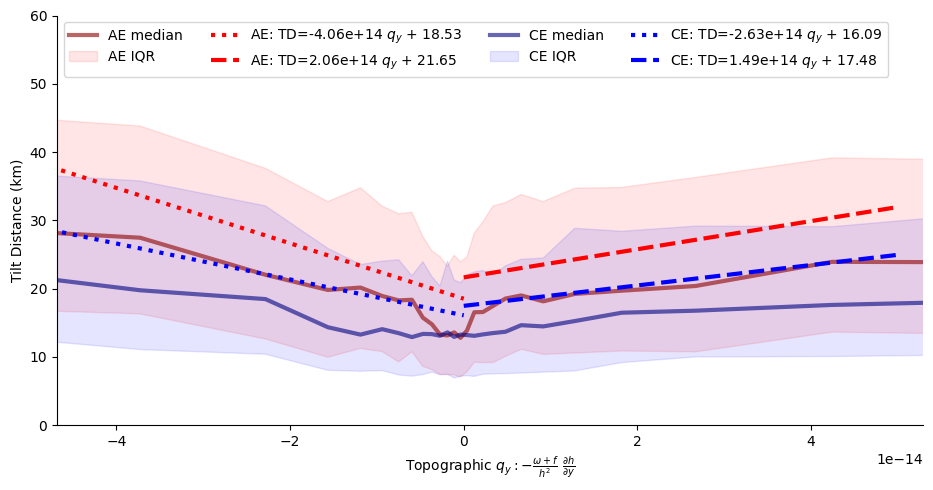

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['Gradq_topo'])
# x_min, x_max = -.25e-12, .25e-12   # <-- set your limits
x_min, x_max = df_all.Gradq_topo.min(), df_all.Gradq_topo.max()   # <-- set your limits
mask_cap = (df_all.Gradq_topo >= x_min) & (df_all.Gradq_topo <= x_max)
N_all = df_all[mask_cap].Gradq_topo.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['Gradq_topo', 'TiltDis'])

    xval = df_masked['Gradq_topo'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    for l, (Nmin, Nmax) in enumerate(zip([-.5e-13, 0],
                          [0, .5e-13])):
        mask_reg = (xval >= Nmin) & (xval <= Nmax)
    
        if mask_reg.sum() > 2:
            xr = xval[mask_reg]
            yr = tilt[mask_reg]
    
            m, c, r, p, se = linregress(xr, yr)
    
            x_fit = np.linspace(Nmin, Nmax, 200)
            y_fit = m * x_fit + c
    
            ax.plot(x_fit, y_fit, ':' if l==0 else'--', lw=3, color=styles[cyc]['fill'],
                    label=fr'{cyc}: TD={m:.2e} $q_y$ + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 60)
# # ax.set_xlim(-.25e-12, .25e-12)
# ax.set_xlim(-1e-13, 1e-13)
lo, hi = np.percentile(df_eddies.Gradq_topo, [10, 90])
ax.set_xlim(lo, hi)
ax.set_xlabel(r'Topographic $q_y: -\frac{\omega + f}{h^2}\ \frac{\partial h}{\partial y}$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=4)

plt.tight_layout()
plt.show()


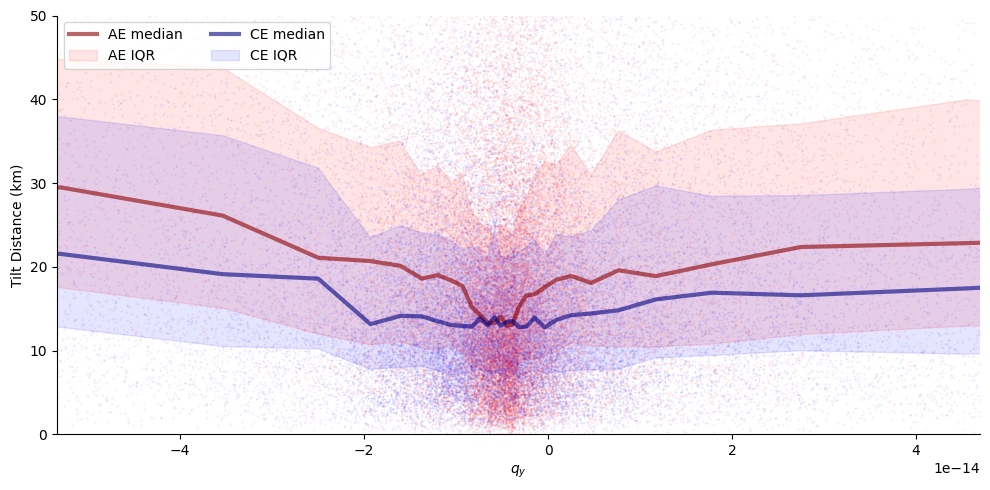

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['Gradq'])
x_min, x_max = -.1e-12, .1e-12   # <-- set your limits
mask_cap = (df_all.Gradq >= x_min) & (df_all.Gradq <= x_max)
N_all = df_all[mask_cap].Gradq.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['Gradq', 'TiltDis'])

    xval = df_masked['Gradq'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
               color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # # Nmin, Nmax = np.nanpercentile(N_all, [10, 90])
    # Nmin, Nmax = bin_centers.min(), bin_centers.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label=f'{cyc}: TD={m:.2e} f + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 50)
lo, hi = np.percentile(df_eddies.Gradq, [10, 90])
ax.set_xlim(lo, hi)
ax.set_xlabel(r'$q_y$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)

plt.tight_layout()
plt.show()


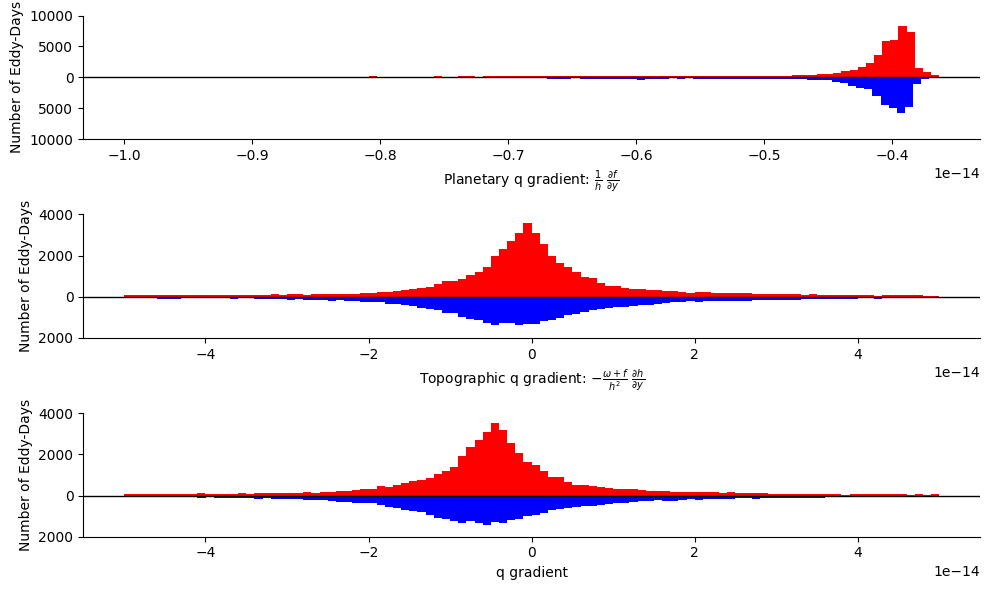

In [128]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=False)

# --- Plot 0 ---
ax = axs[0]
x2 = 1e-14
ages_ae = df_eddies[(df_eddies.Cyc=='AE')&(df_eddies.Gradq_plan.abs()<=x2)].Gradq_plan
ages_ce = df_eddies[(df_eddies.Cyc=='CE')&(df_eddies.Gradq_plan.abs()<=x2)].Gradq_plan
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'Planetary q gradient: $\frac{1}{h}\ \frac{\partial f}{\partial y}$')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_xlim(0, x2)

# --- Plot 1 ---
ax = axs[1]
x3 = 5e-14
ages_ae = df_eddies[(df_eddies.Cyc=='AE')&(df_eddies.Gradq_topo.abs()<=x3)].Gradq_topo
ages_ce = df_eddies[(df_eddies.Cyc=='CE')&(df_eddies.Gradq_topo.abs()<=x3)].Gradq_topo
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'Topographic q gradient: $-\frac{\omega + f}{h^2}\ \frac{\partial h}{\partial y}$')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_ylim(-3000, 3000)

# --- Plot 2 ---
ax = axs[2]
x1 = 5e-14
ages_ae = df_eddies[(df_eddies.Cyc=='AE')&(df_eddies.Gradq.abs()<=x1)].Gradq
ages_ce = df_eddies[(df_eddies.Cyc=='CE')&(df_eddies.Gradq.abs()<=x1)].Gradq
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'q gradient')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_ylim(-3000, 3000)

plt.tight_layout()
plt.show()


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


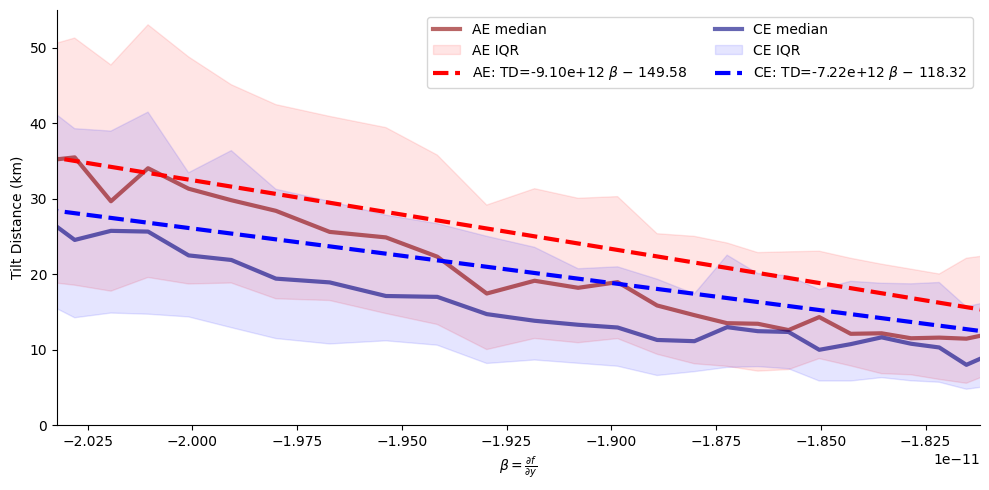

In [126]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['beta'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.beta.min(), df_all.beta.max()  # <-- set your limits 

mask_cap = (df_all.beta >= x_min) & (df_all.beta <= x_max)
N_all = df_all[mask_cap].beta.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['beta', 'TiltDis'])

    xval = df_masked['beta'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    Nmin, Nmax = xval.min(), xval.max()
    mask_reg = (xval >= Nmin) & (xval <= Nmax)

    if mask_reg.sum() > 2:
        xr = xval[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_fit = np.linspace(Nmin, Nmax, 200)
        y_fit = m * x_fit + c

        ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')

# ax.plot([-1.5e-11, -2e-11], [20, 25])
# ax.plot([-2e-11, -2.15e-11], [25, 35])

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
lo, hi = np.percentile(df_eddies.beta, [10, 90])
ax.set_xlim(lo, hi)
ax.set_xlabel(r'$\beta=\frac{\partial f}{\partial y}$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()



/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


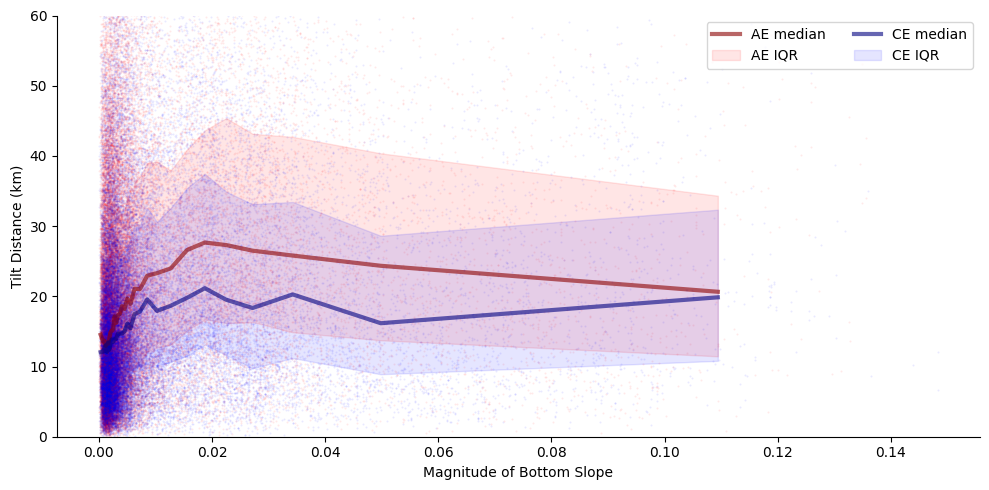

In [78]:
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['s'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.s.min(), df_all.s.max()  # <-- set your limits 

mask_cap = (df_all.s >= x_min) & (df_all.s <= x_max)
N_all = df_all[mask_cap].s.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['s', 'TiltDis'])

    xval = df_masked['s'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
               color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label=fr'{cyc}: TD={m:.2e} $\beta$ + {c:.2f}')

# ax.plot([-1.5e-11, -2e-11], [20, 25])
# ax.plot([-2e-11, -2.15e-11], [25, 35])

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 60)
# lo, hi = np.percentile(df_eddies.Ro, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Magnitude of Bottom Slope')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


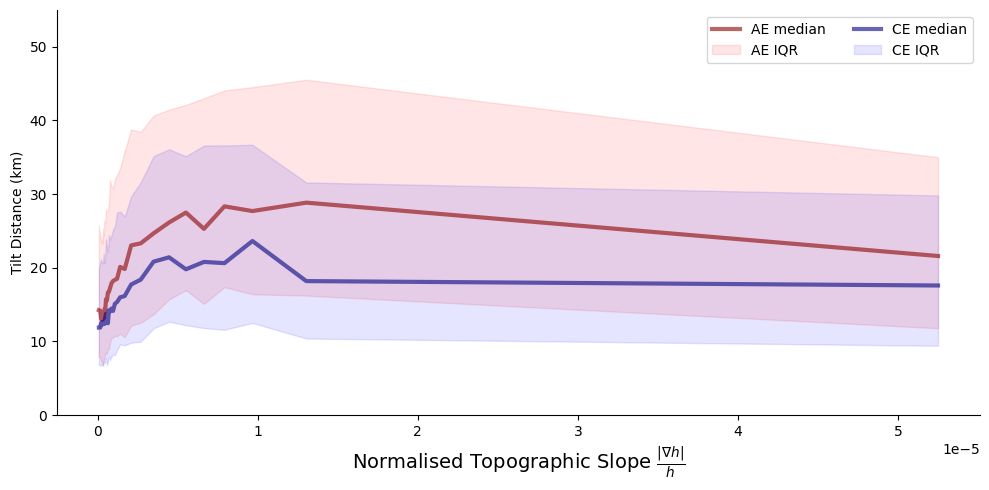

In [137]:
df_eddies['gamma'] = df_eddies.s / df_eddies.h

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['gamma'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.gamma.min(), df_all.gamma.max()  # <-- set your limits 

mask_cap = (df_all.gamma >= x_min) & (df_all.gamma <= x_max)
N_all = df_all[mask_cap].gamma.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['gamma', 'TiltDis'])

    xval = df_masked['gamma'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
# lo, hi = np.percentile(df_eddies.gamma, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Normalised Topographic Slope $\frac{|\nabla h|}{h}$', fontsize=14)
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


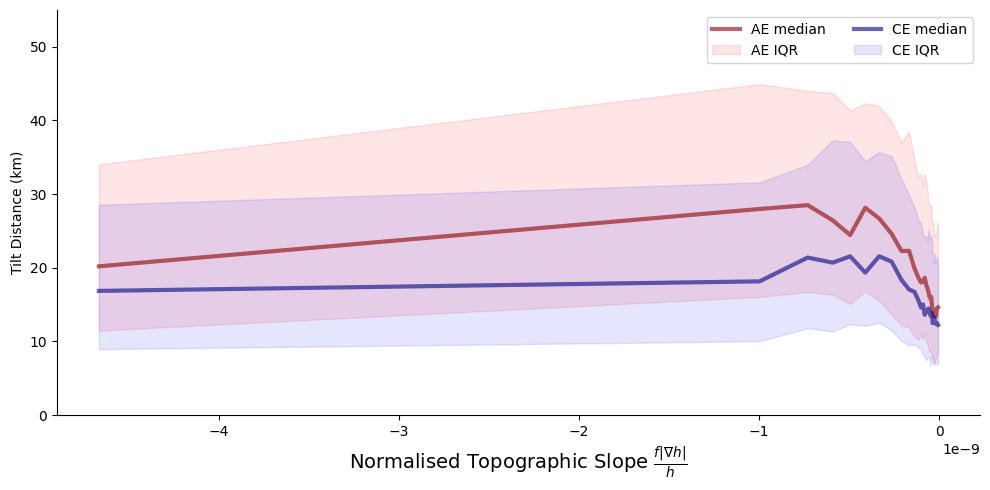

In [139]:
df_eddies['gamma'] = df_eddies.f * df_eddies.s / df_eddies.h

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['gamma'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.gamma.min(), df_all.gamma.max()  # <-- set your limits 

mask_cap = (df_all.gamma >= x_min) & (df_all.gamma <= x_max)
N_all = df_all[mask_cap].gamma.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['gamma', 'TiltDis'])

    xval = df_masked['gamma'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
# lo, hi = np.percentile(df_eddies.gamma, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Normalised Topographic Slope $\frac{f|\nabla h|}{h}$', fontsize=14)
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()




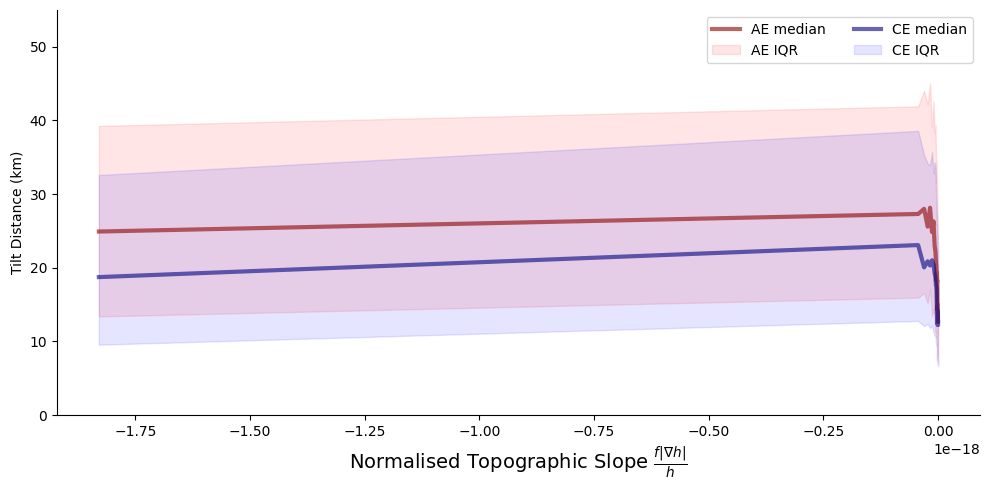

In [142]:
df_eddies['gamma'] = df_eddies.beta * np.abs(dh_dN[df_eddies.ic, df_eddies.jc]) / df_eddies.h**2

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['gamma'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.gamma.min(), df_all.gamma.max()  # <-- set your limits 

mask_cap = (df_all.gamma >= x_min) & (df_all.gamma <= x_max)
N_all = df_all[mask_cap].gamma.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['gamma', 'TiltDis'])

    xval = df_masked['gamma'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
# lo, hi = np.percentile(df_eddies.gamma, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Normalised Topographic Slope $\frac{f|\nabla h|}{h}$', fontsize=14)
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

In [49]:
H = 5000

hb = H - np.where(h > 2000, h, np.nan)

df_eddies['Q1'] = df_eddies.w + beta[df_eddies.ic, df_eddies.jc] + df_eddies.f*hb[df_eddies.ic, df_eddies.jc]/H

df_eddies['Qy_top'] = df_eddies.f*s[df_eddies.ic, df_eddies.jc]/H


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


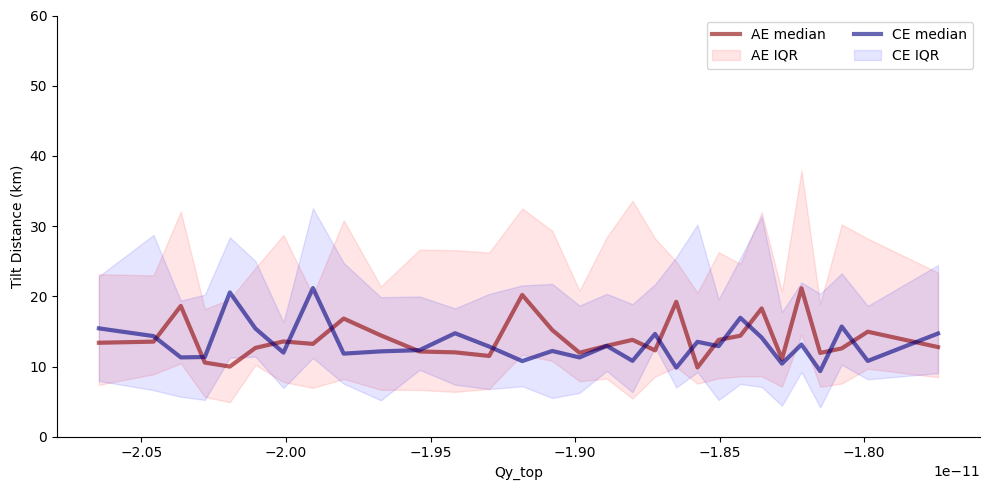

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['Qy_top'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.Qy_top.min(), df_all.Qy_top.max()  # <-- set your limits 

mask_cap = (df_all.Qy_top >= x_min) & (df_all.Qy_top <= x_max)
N_all = df_all[mask_cap].beta.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['Qy_top', 'TiltDis'])

    xval = df_masked['Qy_top'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label=fr'{cyc}: TD={m:.2e} $\beta$ + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 60)
# ax.set_xlim(-2e-11, 0)
# lo, hi = np.percentile(df_eddies.beta, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Qy_top')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()
